# NBA Playoff Prediction - Neural Network

This notebook implements neural networks with L2 regularization for predicting NBA playoff qualification.


In [38]:
import os

DATA_PATH = "./data/processed"
MODEL_PATH = "./models/neural_network"
RESULTS_PATH = "./results/neural_network"

os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

In [39]:
import numpy as np
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
print(f"TensorFlow version: {tf.__version__}")
# Load all 4 feature transformation versions
data_versions = {
    'baseline': ('scaled', 'Baseline (untransformed)'),
    'poly2': ('poly2', 'Polynomial degree 2'),
    'poly3': ('poly3', 'Polynomial degree 3'),
    'pca': ('pca', 'PCA (95% variance)')
}

# Load labels (same for all versions)
y_train = np.load(f"{DATA_PATH}/y_train.npy")
y_val = np.load(f"{DATA_PATH}/y_val.npy")
y_test = np.load(f"{DATA_PATH}/y_test.npy")

# Load all versions
X_data = {}
for name, (suffix, desc) in data_versions.items():
    X_data[name] = {
        'train': np.load(f"{DATA_PATH}/X_train_{suffix}.npy"),
        'val': np.load(f"{DATA_PATH}/X_val_{suffix}.npy"),
        'test': np.load(f"{DATA_PATH}/X_test_{suffix}.npy"),
        'desc': desc
    }
    print(f"{desc}: Train={X_data[name]['train'].shape}, Val={X_data[name]['val'].shape}, Test={X_data[name]['test'].shape}")

# Set X_train, X_val, X_test to baseline for compatibility (will be overridden in loops)
X_train = X_data['baseline']['train']
X_val = X_data['baseline']['val']
X_test = X_data['baseline']['test']

with open(f"{DATA_PATH}/feature_names.json", 'r') as f:
    feature_cols = json.load(f)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Features: {len(feature_cols)}")

TensorFlow version: 2.20.0
Baseline (untransformed): Train=(446, 27), Val=(120, 27), Test=(120, 27)
Polynomial degree 2: Train=(446, 405), Val=(120, 405), Test=(120, 405)
Polynomial degree 3: Train=(446, 4059), Val=(120, 4059), Test=(120, 4059)
PCA (95% variance): Train=(446, 13), Val=(120, 13), Test=(120, 13)
Train: (446, 27), Val: (120, 27), Test: (120, 27)
Features: 27


## Model Configuration


In [40]:
class_weight = {
    0: len(y_train) / (2 * (len(y_train) - y_train.sum())),
    1: len(y_train) / (2 * y_train.sum())
}
print(f"Class weights: {class_weight}")

Class weights: {0: np.float64(1.0825242718446602), 1: np.float64(0.9291666666666667)}


In [41]:
# Note: Feature count will vary by transformation version

layer_architectures = [
    {'name': '2-Layer', 'layers': [128, 64]},
    {'name': '2-Layer', 'layers': [64, 32]},
    {'name': '3-Layer', 'layers': [256, 128, 64]},
    {'name': '5-Layer', 'layers': [512, 256, 128, 64, 32]},
]

regularization_configs = [
    {'name': 'L2-0', 'l2': 0},
    {'name': 'L2-0.01', 'l2': 0.01},
    {'name': 'L2-0.001', 'l2': 0.001},
    {'name': 'L2-0.1', 'l2': 0.1},
    {'name': 'L2-1', 'l2': 1},
    {'name': 'L2-10', 'l2': 10},
]

print(f"{len(layer_architectures)} layer architectures")
print(f"{len(regularization_configs)} regularization configurations")
print(f"Total models: {len(layer_architectures) * len(regularization_configs)}")

4 layer architectures
6 regularization configurations
Total models: 24


## Train Models with Regularization


In [42]:
def build_model(input_dim, layer_sizes, reg):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
    ])
    
    for units in layer_sizes:
        model.add(layers.Dense(units, activation='relu', kernel_regularizer=reg))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

all_results = []
model_counter = 0
total_models = len(data_versions) * len(layer_architectures) * len(regularization_configs)

print("\n" + "=" * 80)
print(f"TRAINING {total_models} MODELS (4 feature transformations × {len(layer_architectures)} architectures × {len(regularization_configs)} regularization)")
print("=" * 80 + "\n")

for version_name, (suffix, version_desc) in data_versions.items():
    print(f"\n{'='*80}")
    print(f"Feature Transformation: {version_desc}")
    print(f"{'='*80}")
    
    # Use this version's data
    X_train = X_data[version_name]['train']
    X_val = X_data[version_name]['val']
    X_test = X_data[version_name]['test']
    
    for arch_config in layer_architectures:
        arch_name = arch_config['name']
        layer_sizes = arch_config['layers']
        
        print(f"{arch_name} Architecture: {layer_sizes}")
        print("-" * 60)
        
        for reg_config in regularization_configs:
            model_counter += 1
            model_name = f"{version_name}_{arch_name}_{reg_config['name']}"
            
            l2_value = reg_config.get('l2', 0.0)
            
            if l2_value > 0:
                reg = l2(l2_value)
            else:
                reg = None
            
            model = build_model(X_train.shape[1], layer_sizes, reg)
            
            early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
            batch_size = max(8, min(32, len(X_train) // 4))
            
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=200,
                batch_size=batch_size,
                class_weight=class_weight,
                callbacks=[early_stop],
                verbose=0
            )
            
            y_test_pred_prob = model.predict(X_test, verbose=0, batch_size=batch_size).flatten()
            y_test_pred = (y_test_pred_prob > 0.5).astype(int)
            
            test_acc = accuracy_score(y_test, y_test_pred)
            test_auc = roc_auc_score(y_test, y_test_pred_prob)
            test_precision = precision_score(y_test, y_test_pred)
            test_recall = recall_score(y_test, y_test_pred)
            test_f1 = f1_score(y_test, y_test_pred)
            
            results = {
                'model_id': f"{model_counter:02d}",
                'version': version_name,
                'version_desc': version_desc,
                'architecture': arch_name,
                'regularization': reg_config['name'],
                'test_acc': test_acc,
                'test_auc': test_auc,
                'test_precision': test_precision,
                'test_recall': test_recall,
                'test_f1': test_f1,
            }
            
            all_results.append(results)
            print(f"  {reg_config['name']}: Acc={test_acc:.4f}, Prec={test_precision:.4f}, Rec={test_recall:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}")
            
            model.save(f"{MODEL_PATH}/{model_name}.keras")
        
        print()

print("Training complete")


TRAINING 96 MODELS (4 feature transformations × 4 architectures × 6 regularization)


Feature Transformation: Baseline (untransformed)
2-Layer Architecture: [128, 64]
------------------------------------------------------------
  L2-0: Acc=0.8500, Prec=0.7875, Rec=0.9844, F1=0.8750, AUC=0.9732
  L2-0.01: Acc=0.8750, Prec=0.8182, Rec=0.9844, F1=0.8936, AUC=0.9824
  L2-0.001: Acc=0.8750, Prec=0.8182, Rec=0.9844, F1=0.8936, AUC=0.9768
  L2-0.1: Acc=0.8750, Prec=0.8267, Rec=0.9688, F1=0.8921, AUC=0.9766
  L2-1: Acc=0.5333, Prec=0.5333, Rec=1.0000, F1=0.6957, AUC=0.9343
  L2-10: Acc=0.5333, Prec=0.5333, Rec=1.0000, F1=0.6957, AUC=0.8305

2-Layer Architecture: [64, 32]
------------------------------------------------------------
  L2-0: Acc=0.8500, Prec=0.7949, Rec=0.9688, F1=0.8732, AUC=0.9718
  L2-0.01: Acc=0.8917, Prec=0.8400, Rec=0.9844, F1=0.9065, AUC=0.9796
  L2-0.001: Acc=0.8583, Prec=0.7975, Rec=0.9844, F1=0.8811, AUC=0.9757
  L2-0.1: Acc=0.8917, Prec=0.8493, Rec=0.9688, F1=0.9051, 

In [43]:
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('test_auc', ascending=False)
results_df.to_csv(f"{RESULTS_PATH}/model_results.csv", index=False)

print("\nModel Results Summary:")
print(results_df[['architecture', 'test_acc', 'test_precision', 'test_recall', 'test_f1', 'test_auc']].to_string(index=False))


Model Results Summary:
architecture  test_acc  test_precision  test_recall  test_f1  test_auc
     2-Layer  0.875000        0.818182     0.984375 0.893617  0.982422
     3-Layer  0.883333        0.828947     0.984375 0.900000  0.981585
     3-Layer  0.883333        0.828947     0.984375 0.900000  0.980748
     2-Layer  0.891667        0.840000     0.984375 0.906475  0.979632
     5-Layer  0.908333        0.863014     0.984375 0.919708  0.978516
     2-Layer  0.875000        0.818182     0.984375 0.893617  0.976842
     5-Layer  0.925000        0.923077     0.937500 0.930233  0.976842
     2-Layer  0.875000        0.826667     0.968750 0.892086  0.976562
     5-Layer  0.866667        0.807692     0.984375 0.887324  0.976562
     2-Layer  0.858333        0.797468     0.984375 0.881119  0.975725
     2-Layer  0.891667        0.849315     0.968750 0.905109  0.975725
     3-Layer  0.850000        0.794872     0.968750 0.873239  0.974609
     2-Layer  0.850000        0.787500     0.984375 0

In [44]:
print("Performance by architecture:")
arch_summary = results_df.groupby('architecture').agg({
    'test_acc': 'mean',
    'test_precision': 'mean',
    'test_recall': 'mean',
    'test_f1': 'mean',
    'test_auc': 'mean'
}).round(4)
print(arch_summary)

Performance by architecture:
              test_acc  test_precision  test_recall  test_f1  test_auc
architecture                                                          
2-Layer         0.7583          0.7139       0.9847   0.8216    0.8784
3-Layer         0.7444          0.7096       0.9818   0.8151    0.8007
5-Layer         0.7264          0.6919       0.9857   0.8046    0.7751


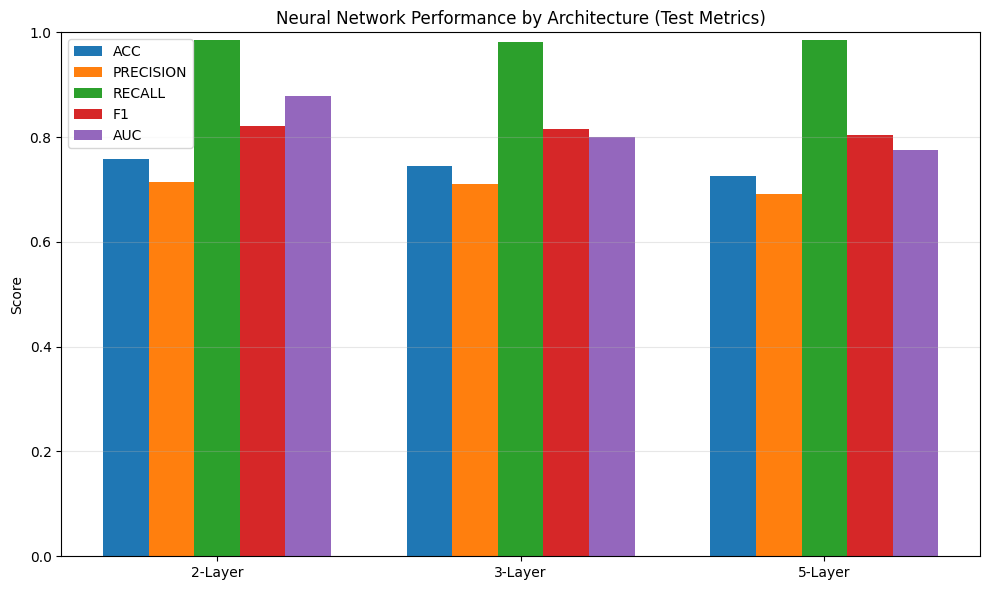

In [45]:
# Visualization: How architecture affects performance metrics
# Uses existing `results_df` (no retraining needed)

# Figure out which metric columns actually exist in results_df
all_metric_cols = ['test_acc', 'test_precision', 'test_recall', 'test_f1', 'test_auc']
available_metrics = [m for m in all_metric_cols if m in results_df.columns]

# Aggregate only over available metrics
arch_metrics = results_df.groupby('architecture')[available_metrics].mean().round(5)

architectures = arch_metrics.index.tolist()
metrics = available_metrics
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'][:len(metrics)]

x = range(len(architectures))
bar_width = 0.15

plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    plt.bar(
        [p + i * bar_width for p in x],
        arch_metrics[metric].values,
        width=bar_width,
        color=colors[i],
        label=metric.replace('test_', '').upper()
    )

plt.xticks([p + (len(metrics) - 1) / 2 * bar_width for p in x], architectures, rotation=0)
plt.ylim(0, 1.0)
plt.ylabel('Score')
plt.title('Neural Network Performance by Architecture (Test Metrics)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/architecture_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


## Evaluate Models


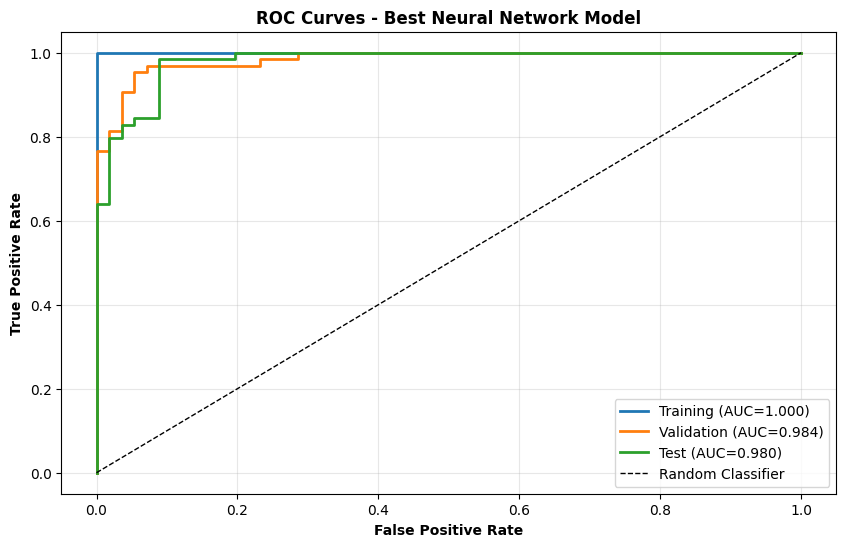

In [46]:
# ROC Curves for Train, Val, Test sets
from sklearn.metrics import roc_curve

# Get best model information (if not already defined)
if 'best_version' not in globals() or 'best_model' not in globals():
    best_model_row = results_df.iloc[0]
    best_version = best_model_row['version']
    best_version_desc = best_model_row['version_desc']
    best_model_name = f"{best_model_row['version']}_{best_model_row['architecture']}_{best_model_row['regularization']}"
    best_model = keras.models.load_model(f"{MODEL_PATH}/{best_model_name}.keras")

plt.figure(figsize=(10, 6))

# Use best version's data for ROC curves
X_train_best = X_data[best_version]['train']
X_val_best = X_data[best_version]['val']
X_test_best = X_data[best_version]['test']

for name, X_data_roc, y_data in [
    ("Training", X_train_best, y_train),
    ("Validation", X_val_best, y_val),
    ("Test", X_test_best, y_test)
]:
    y_prob = best_model.predict(X_data_roc, verbose=0, batch_size=batch_size).flatten()
    fpr, tpr, _ = roc_curve(y_data, y_prob)
    auc = roc_auc_score(y_data, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves - Best Neural Network Model', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"{RESULTS_PATH}/roc_curves.png", dpi=300, bbox_inches='tight')
plt.show()

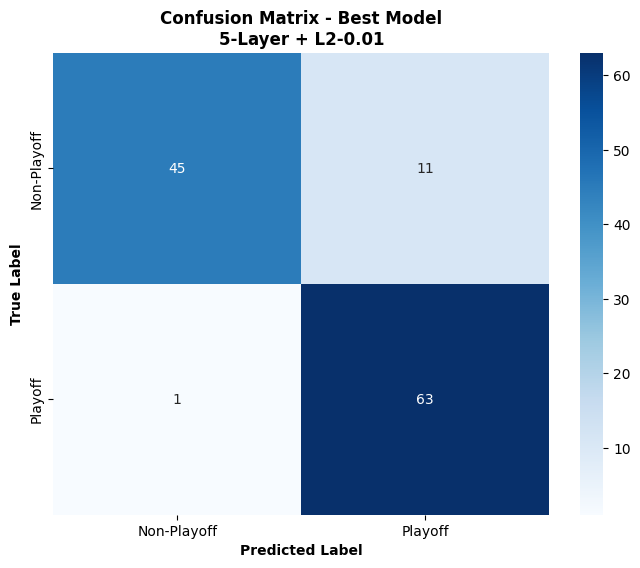

In [47]:
# Confusion Matrix Heatmap for Best Model
# Get best model information and confusion matrix (if not already defined)
if 'best_model_row' not in globals() or 'conf_matrix' not in globals():
    best_model_row = results_df.iloc[0]
    best_version = best_model_row['version']
    best_version_desc = best_model_row['version_desc']
    best_model_name = f"{best_model_row['version']}_{best_model_row['architecture']}_{best_model_row['regularization']}"
    best_model = keras.models.load_model(f"{MODEL_PATH}/{best_model_name}.keras")
    
    # Use best version's test data
    X_test = X_data[best_version]['test']
    y_test_pred_prob = best_model.predict(X_test, verbose=0, batch_size=batch_size).flatten()
    y_test_pred = (y_test_pred_prob > 0.5).astype(int)
    
    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix as cm
    conf_matrix = cm(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Non-Playoff', 'Playoff'],
            yticklabels=['Non-Playoff', 'Playoff'])
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.title(f'Confusion Matrix - Best Model\n{best_model_row["architecture"]} + {best_model_row["regularization"]}', 
          fontweight='bold')
plt.savefig(f"{RESULTS_PATH}/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

## Hyperparameter Tuning


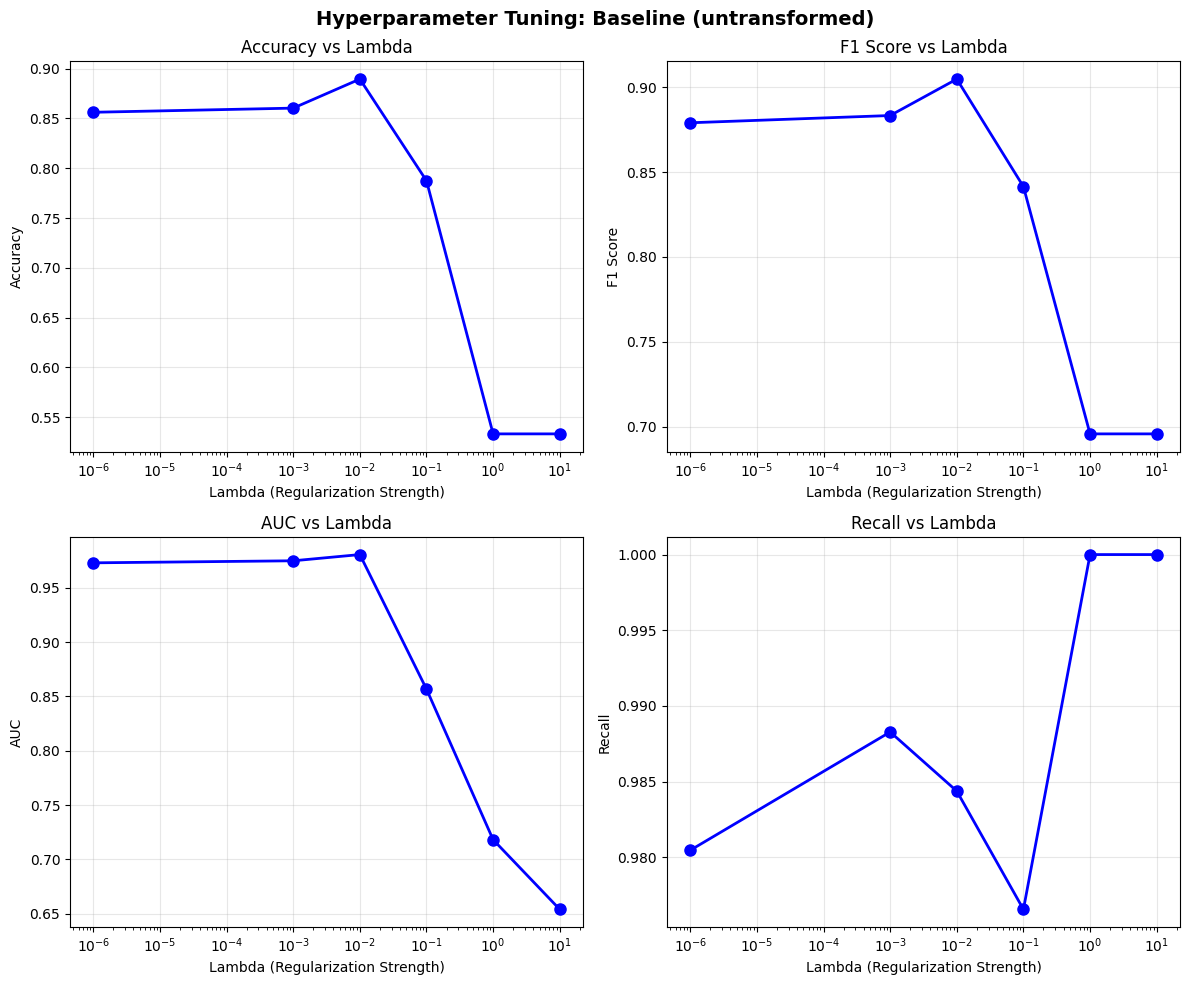

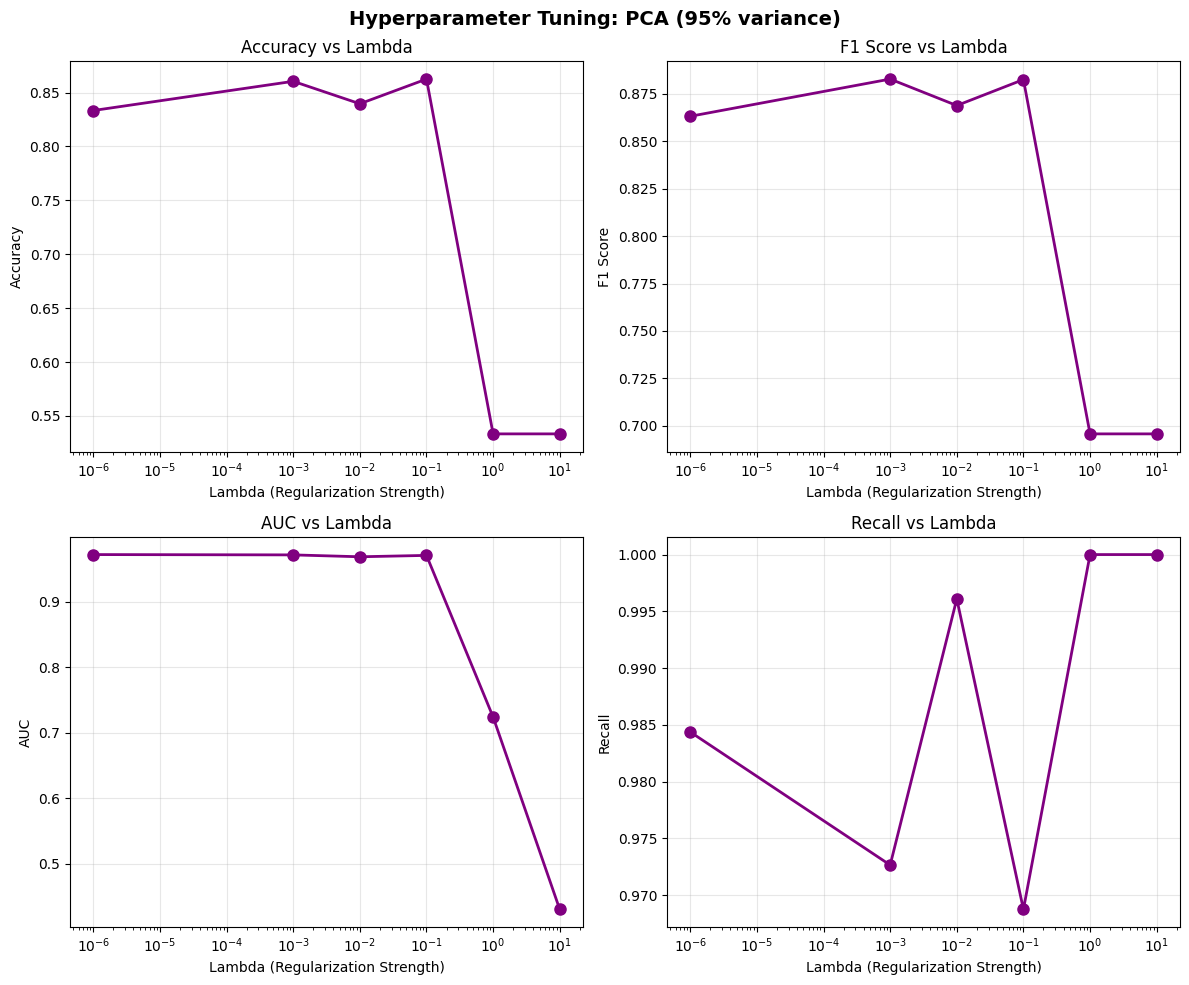

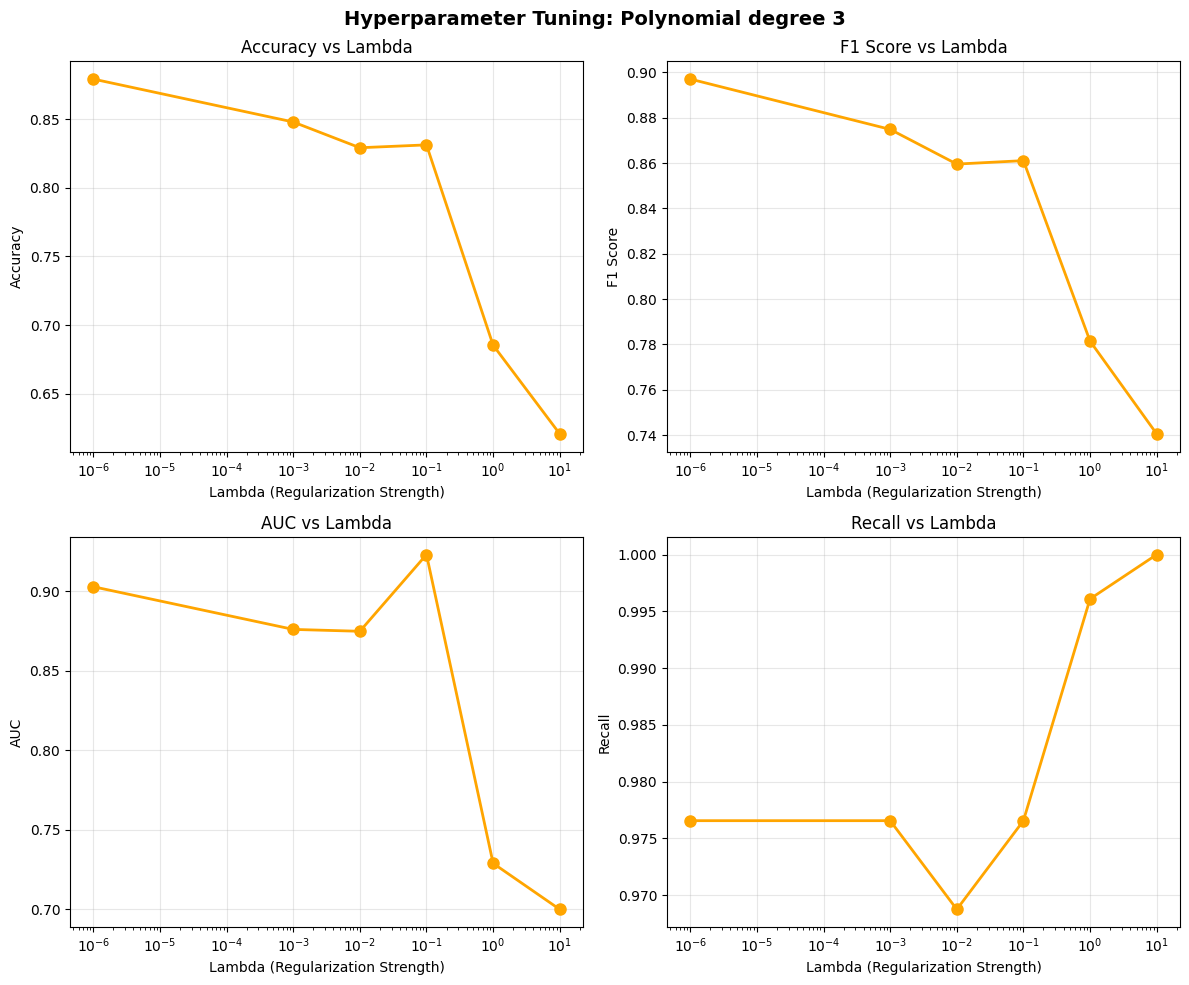

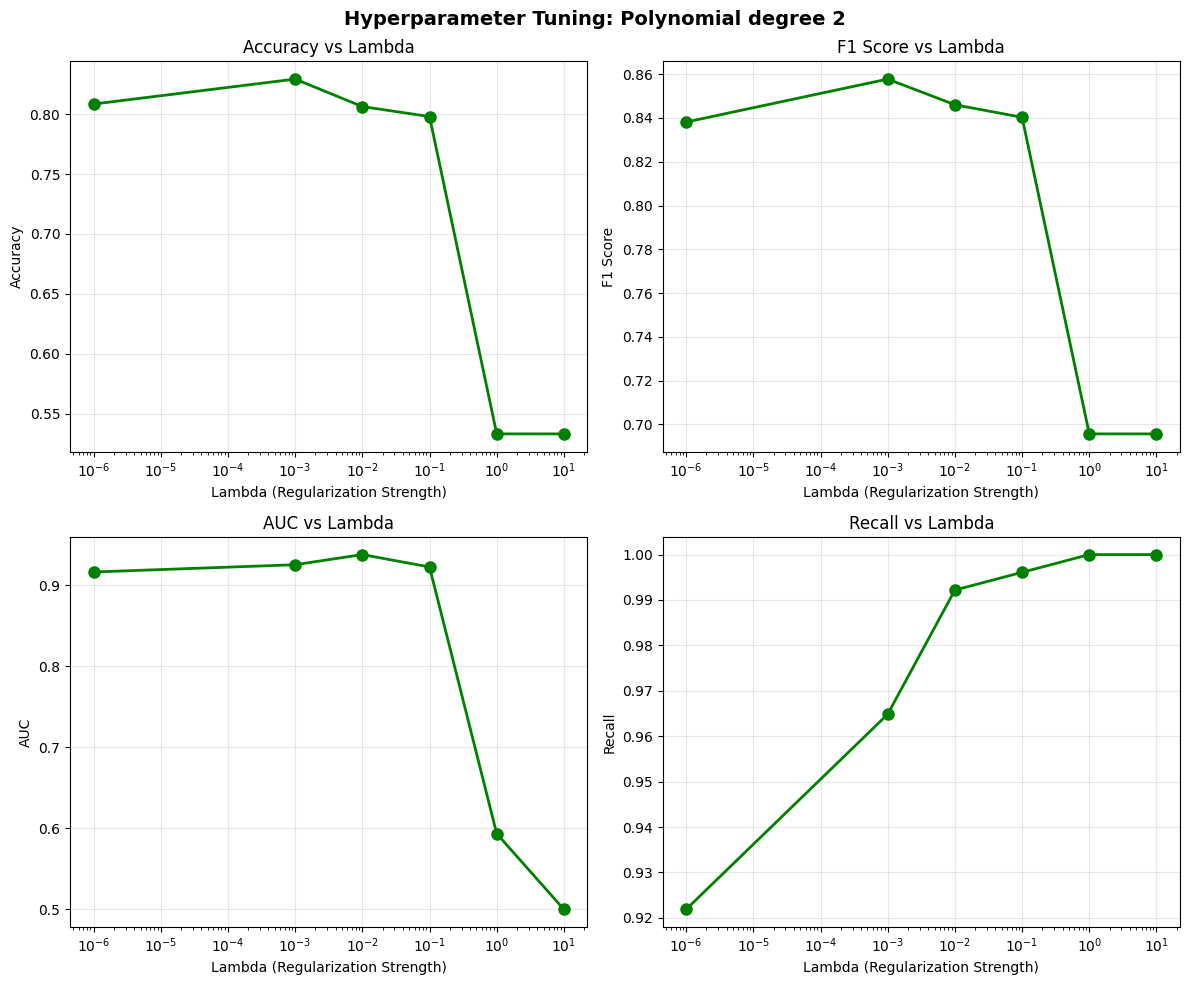

In [48]:
# Plot hyperparameter tuning results - one figure per feature transformation
version_colors = {
    'Baseline (untransformed)': 'blue',
    'Polynomial degree 2': 'green',
    'Polynomial degree 3': 'orange',
    'PCA (95% variance)': 'purple'
}

# Get best model information for highlighting
if 'best_version' not in globals() or 'best_version_desc' not in globals():
    best_model_row = results_df.iloc[0]
    best_version = best_model_row['version']
    best_version_desc = best_model_row['version_desc']

# Create one figure per version
for version_desc in results_df['version_desc'].unique():
    version_data = results_df[results_df['version_desc'] == version_desc].copy()
    
    # Group by regularization and calculate mean metrics for this version
    reg_summary = version_data.groupby('regularization').agg({
        'test_acc': 'mean',
        'test_f1': 'mean',
        'test_auc': 'mean',
        'test_recall': 'mean'
    }).reset_index()
    
    # Sort by regularization strength order
    reg_order = ['L2-0', 'L2-0.001', 'L2-0.01', 'L2-0.1', 'L2-1', 'L2-10']
    reg_summary['regularization'] = pd.Categorical(reg_summary['regularization'], categories=reg_order, ordered=True)
    reg_summary = reg_summary.sort_values('regularization')
    
    # Create plot with LogPredict-style lambda handling
    plot_df = reg_summary.copy()
    plot_df['plot_lambda'] = plot_df['regularization'].apply(lambda x: 1e-6 if x == 'L2-0' else float(x.split('-')[1]))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Hyperparameter Tuning: {version_desc}', fontsize=14, fontweight='bold')
    
    # Check if this version has the best model
    is_best_version = (version_desc == best_version_desc)
    if is_best_version:
        best_reg = best_model_row['regularization']
        best_plot_lambda = plot_df[plot_df['regularization'] == best_reg]['plot_lambda'].values[0]
    
    color = version_colors[version_desc]
    
    # Accuracy plot
    axes[0, 0].plot(plot_df['plot_lambda'], plot_df['test_acc'], 'o-', linewidth=2, markersize=8, color=color)
    if is_best_version:
        best_acc_plot = plot_df[plot_df['regularization'] == best_reg]['test_acc'].values[0]
        axes[0, 0].plot(best_plot_lambda, best_acc_plot, 's', markersize=10, color='red', label='Best model', zorder=5)
        axes[0, 0].legend()
    axes[0, 0].set_xlabel('Lambda (Regularization Strength)')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Accuracy vs Lambda')
    axes[0, 0].set_xscale('log')
    axes[0, 0].grid(True, alpha=0.3)
    
    # F1 Score plot
    axes[0, 1].plot(plot_df['plot_lambda'], plot_df['test_f1'], 'o-', linewidth=2, markersize=8, color=color)
    if is_best_version:
        best_f1_plot = plot_df[plot_df['regularization'] == best_reg]['test_f1'].values[0]
        axes[0, 1].plot(best_plot_lambda, best_f1_plot, 's', markersize=10, color='red', zorder=5)
    axes[0, 1].set_xlabel('Lambda (Regularization Strength)')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('F1 Score vs Lambda')
    axes[0, 1].set_xscale('log')
    axes[0, 1].grid(True, alpha=0.3)
    
    # AUC plot
    axes[1, 0].plot(plot_df['plot_lambda'], plot_df['test_auc'], 'o-', linewidth=2, markersize=8, color=color)
    if is_best_version:
        best_auc_plot = plot_df[plot_df['regularization'] == best_reg]['test_auc'].values[0]
        axes[1, 0].plot(best_plot_lambda, best_auc_plot, 's', markersize=10, color='red', zorder=5)
    axes[1, 0].set_xlabel('Lambda (Regularization Strength)')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].set_title('AUC vs Lambda')
    axes[1, 0].set_xscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall plot
    axes[1, 1].plot(plot_df['plot_lambda'], plot_df['test_recall'], 'o-', linewidth=2, markersize=8, color=color)
    if is_best_version:
        best_recall_plot = plot_df[plot_df['regularization'] == best_reg]['test_recall'].values[0]
        axes[1, 1].plot(best_plot_lambda, best_recall_plot, 's', markersize=10, color='red', zorder=5)
    axes[1, 1].set_xlabel('Lambda (Regularization Strength)')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].set_title('Recall vs Lambda')
    axes[1, 1].set_xscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{RESULTS_PATH}/regularization_comparison_{version_desc.replace(' ', '_').replace('(', '').replace(')', '')}.png", dpi=300, bbox_inches='tight')
    plt.show()


## Final Model with Best Hyperparameters


In [51]:
best_model_row = results_df.iloc[0]
best_version = best_model_row['version']
best_version_desc = best_model_row['version_desc']
best_model_name = f"{best_model_row['version']}_{best_model_row['architecture']}_{best_model_row['regularization']}"

# Load best model and verify input shape
best_model = keras.models.load_model(f"{MODEL_PATH}/{best_model_name}.keras")

# Use best version's test data
X_test = X_data[best_version]['test']

# Verify input shape matches model expectations
expected_input_shape = best_model.input_shape[1]
actual_input_shape = X_test.shape[1]

if expected_input_shape != actual_input_shape:
    raise ValueError(
        f"Model input shape mismatch!\n"
        f"Model expects {expected_input_shape} features, but data has {actual_input_shape} features.\n"
        f"This likely means the feature set changed (e.g., columns with 50%+ NaNs were removed).\n"
        f"Please retrain the models with the current feature set."
    )

y_test_pred_prob = best_model.predict(X_test, verbose=0, batch_size=batch_size).flatten()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix as cm
test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
conf_matrix = cm(y_test, y_test_pred)

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"\nBest model by Test AUC: {best_model_row['version_desc']} + {best_model_row['architecture']} + {best_model_row['regularization']}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"\nConfusion Matrix:")
print(conf_matrix)


SUMMARY

Best model by Test AUC: Baseline (untransformed) + 2-Layer + L2-0.01
Test Accuracy: 0.8917
Test Precision: 0.8400
Test Recall: 0.9844
Test F1 Score: 0.9065

Confusion Matrix:
[[44 12]
 [ 1 63]]


In [50]:
# Model performance comparison table
print("\n" + "=" * 80)
print("DETAILED RESULTS: All 24 Models")
print("=" * 80)
cols = [
    'model_id',
    'version_desc',  # Dataset / feature transformation
    'architecture',
    'regularization',
    'test_acc',
    'test_auc',
    'test_f1',
    'test_precision',
    'test_recall',
]
# Only keep columns that actually exist in results_df
cols_existing = [c for c in cols if c in results_df.columns]
print(results_df[cols_existing].to_string(index=False, float_format=lambda x: f"{x:.5f}"))

print("\n" + "=" * 80)
print("PERFORMANCE BY FEATURE TRANSFORMATION")
print("=" * 80)
metrics_for_agg = [m for m in ['test_acc', 'test_auc', 'test_f1', 'test_precision', 'test_recall'] if m in results_df.columns]
agg_dict = {m: ['mean', 'std', 'min', 'max'] for m in metrics_for_agg}
version_stats = results_df.groupby('version_desc').agg(agg_dict).round(4)
print(version_stats)

print("\n" + "=" * 80)
print("PERFORMANCE BY ARCHITECTURE")
print("=" * 80)
arch_stats = results_df.groupby('architecture').agg(agg_dict).round(4)
print(arch_stats)

print("\n" + "=" * 80)
print("PERFORMANCE BY REGULARIZATION")
print("=" * 80)
reg_stats = results_df.groupby('regularization').agg(agg_dict).round(4)
print(reg_stats)


DETAILED RESULTS: All 24 Models
model_id             version_desc architecture regularization  test_acc  test_auc  test_f1  test_precision  test_recall
      02 Baseline (untransformed)      2-Layer        L2-0.01   0.87500   0.98242  0.89362         0.81818      0.98438
      14 Baseline (untransformed)      3-Layer        L2-0.01   0.88333   0.98158  0.90000         0.82895      0.98438
      15 Baseline (untransformed)      3-Layer       L2-0.001   0.88333   0.98075  0.90000         0.82895      0.98438
      08 Baseline (untransformed)      2-Layer        L2-0.01   0.89167   0.97963  0.90647         0.84000      0.98438
      20 Baseline (untransformed)      5-Layer        L2-0.01   0.90833   0.97852  0.91971         0.86301      0.98438
      03 Baseline (untransformed)      2-Layer       L2-0.001   0.87500   0.97684  0.89362         0.81818      0.98438
      93       PCA (95% variance)      5-Layer       L2-0.001   0.92500   0.97684  0.93023         0.92308      0.93750
      0